#Начальные установки

In [35]:
!pip install clickhouse_driver
!pip install h3

In [36]:
import pandas as pd
import numpy as np
import datetime
import sqlalchemy
import seaborn as sns
from clickhouse_driver import Client
from pandas_profiling import ProfileReport
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import tools
from plotly.subplots import make_subplots
import plotly.express as px
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
import h3
import seaborn as sns
import matplotlib.pyplot as plt

In [37]:
client = Client('89.208.84.253',
                port= '59000',
                user='student',
                password='nUrHdn2N',
                secure=False,
                verify=True,
                database='data_analysis',
                compression=False)

In [38]:
result,columns = client.execute("""SELECT v.idhash_client,
       latitude,
       longitude,
       sum(v.client_bill_usd) as client_bill_usd_sum
FROM data_analysis.views v INNER JOIN orders o on v.idhash_order = o.idhash_order
WHERE v.idhash_order > 0 and o.status = 'CP'
GROUP BY idhash_client, latitude, longitude
ORDER BY idhash_client ASC;""",with_column_types=True)
view_data_IQR = pd.DataFrame(result, columns=[tuple[0] for tuple in columns])
view_data_IQR

,idhash_client,latitude,longitude,client_bill_usd_sum
0,39262,57.584268,39.825746,1.720
1,39262,57.584267,39.825745,2.790
2,39262,57.584282,39.825794,1.860
3,48902,57.606331,39.888371,2.650
4,199395,57.639099,39.839841,2.070
...,...,...,...,...
41555,4294468826,57.578313,39.847696,3.760
41556,4294468826,57.591675,39.866699,3.310
41557,4294468826,57.624080,39.852321,8.100
41558,4294468826,57.625189,39.850467,3.135


Слишком медленно для больших наборов данных, поэтому я его уменьшина до 1000 записей

In [47]:
view_data_IQR_new = view_data_IQR.groupby(['latitude','longitude'], as_index=False).nunique()
view_data_IQR_new = view_data_IQR_new.head(1000)

In [48]:
X = view_data_IQR_new.iloc[:,[0, 1]].values


#Иерархическая кластеризация

Строим Дендрограмму, определяем количество кластеров

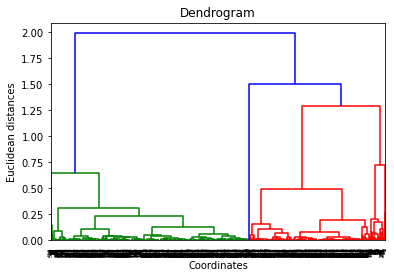

In [49]:
import scipy.cluster.hierarchy as sch
%matplotlib inline
dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward')) #расстояние считаем методом ward
plt.title('Dendrogram')
plt.xlabel('Сoordinates')
plt.ylabel('Euclidean distances')
plt.show()

Видим, что данные можно разделить на 4 кластера

Теперь тренируем наш алгоритм (используем Евклидово расстояние)

In [50]:
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
y_model = model.fit_predict(X)

Визуализируем

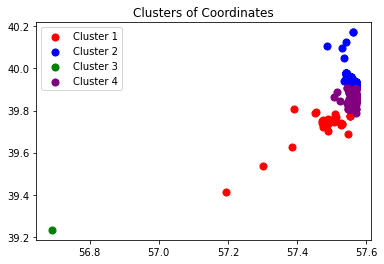

In [65]:
plt.scatter(X[y_model == 0, 0], X[y_model == 0, 1], s=50, color='red', label = 'Cluster 1')
plt.scatter(X[y_model == 1, 0], X[y_model == 1, 1], s=50, color='blue', label = 'Cluster 2')
plt.scatter(X[y_model == 2, 0], X[y_model == 2, 1], s=50, color='green', label = 'Cluster 3')
plt.scatter(X[y_model == 3, 0], X[y_model == 3, 1], s=50, color='purple', label = 'Cluster 4')
plt.title('Clusters of Сoordinates')
plt.legend()
plt.show()

# Сравним с методом с пары

In [56]:
ssd = []
range_n_clusters = [2,3,4,5,6,7,8,9,10]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, init = 'k-means++', max_iter=100) #k-means++ сделала тк с ним , как я поняла, немного умнее выбираются центроиды кластеров
    kmeans.fit(X)
    
    ssd.append(kmeans.inertia_)

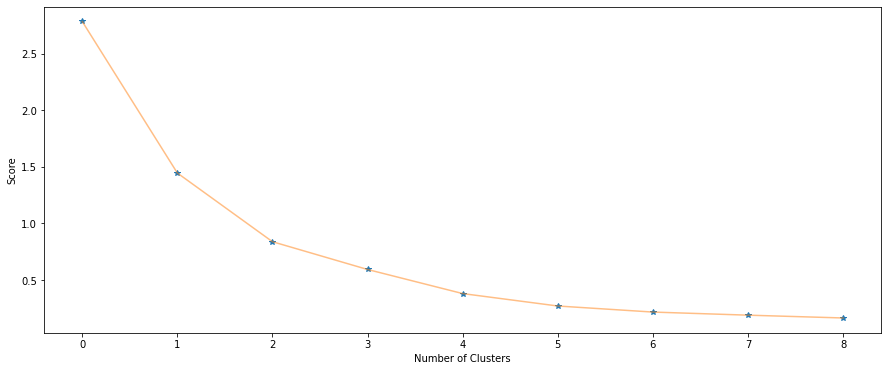

In [57]:
%matplotlib inline
plt.figure(1 , figsize = (15 ,6))
plt.plot(ssd , '*')
plt.plot(ssd , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') 
plt.ylabel('Score')
plt.show()

Берем за основу также 4 кластера

Тренируем

In [60]:
kmeans = KMeans(n_clusters = 4,max_iter=300, n_init=10, algorithm = 'elkan')
y_kmeans = kmeans.fit_predict(X) 

Визуализируем

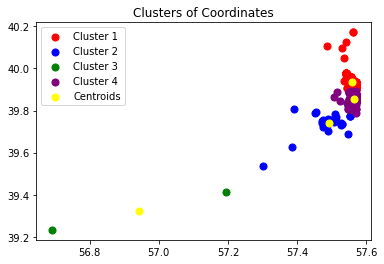

In [63]:
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s=50, color='red', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s=50, color='blue', label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s=50, color='green', label = 'Cluster 3')
plt.scatter(X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], s=50, color='purple', label = 'Cluster 4')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],s=50, color='yellow', label = 'Centroids')
plt.title('Clusters of Сoordinates')
plt.legend()
plt.show()